In this project, we developed a CNN-RNN model for facial expression recognition. The model was trained on a dataset of grayscale facial images and achieved a test accuracy of 58% and a weighted average F1-score of 0.57. While these results demonstrate the model's ability to recognize facial expressions to some extent, there is room for improvement. The validation metrics suggest potential overfitting, which could be addressed through regularization techniques, architecture modifications, or data augmentation. Future work will focus on enhancing the model's generalization ability and exploring advanced techniques such as transfer learning and attention mechanisms. Additionally, expanding the dataset and incorporating temporal information from video sequences could further improve the model's performance and robustness in real-world scenarios.
 

In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import os
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Define data transformations
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
# Configurable dataset paths
data_dir = "./data"
train_val_dataset = ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
test_dataset = ImageFolder(root=os.path.join(data_dir, "test"), transform=test_transform)

In [7]:
# Stratified train-validation split
train_val_labels = [sample[1] for sample in train_val_dataset.samples]
train_indices, val_indices = train_test_split(range(len(train_val_labels)), test_size=0.2,
                                              stratify=train_val_labels, random_state=42)

In [8]:
train_dataset = Subset(train_val_dataset, train_indices)
val_dataset = Subset(train_val_dataset, val_indices)

In [9]:
# DataLoader for batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
# Define the CNN-RNN model
class CNN_RNN_FER(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_RNN_FER, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.lstm = nn.LSTM(input_size=64*12*12, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.features(x)
        B, C, H, W = out.size()
        seq = out.view(B, C*H*W)
        lstm_out, _ = self.lstm(seq.unsqueeze(1))
        logits = self.fc(lstm_out.squeeze(1))
        return logits

Epoch 1/50: Train Loss=1.780, Val Loss=1.708, Val Acc=0.293
Epoch 2/50: Train Loss=1.642, Val Loss=1.525, Val Acc=0.411
Epoch 3/50: Train Loss=1.495, Val Loss=1.425, Val Acc=0.451
Epoch 4/50: Train Loss=1.397, Val Loss=1.355, Val Acc=0.472
Epoch 5/50: Train Loss=1.321, Val Loss=1.291, Val Acc=0.502
Epoch 6/50: Train Loss=1.262, Val Loss=1.301, Val Acc=0.500
Epoch 7/50: Train Loss=1.208, Val Loss=1.244, Val Acc=0.521
Epoch 8/50: Train Loss=1.166, Val Loss=1.215, Val Acc=0.537
Epoch 9/50: Train Loss=1.134, Val Loss=1.214, Val Acc=0.535
Epoch 10/50: Train Loss=1.091, Val Loss=1.200, Val Acc=0.553
Epoch 11/50: Train Loss=1.056, Val Loss=1.217, Val Acc=0.543
Epoch 12/50: Train Loss=1.026, Val Loss=1.205, Val Acc=0.544
Epoch 13/50: Train Loss=0.993, Val Loss=1.205, Val Acc=0.549
Epoch 14/50: Train Loss=0.957, Val Loss=1.196, Val Acc=0.556
Epoch 15/50: Train Loss=0.929, Val Loss=1.215, Val Acc=0.560
Epoch 16/50: Train Loss=0.896, Val Loss=1.206, Val Acc=0.553
Epoch 17/50: Train Loss=0.870, Va

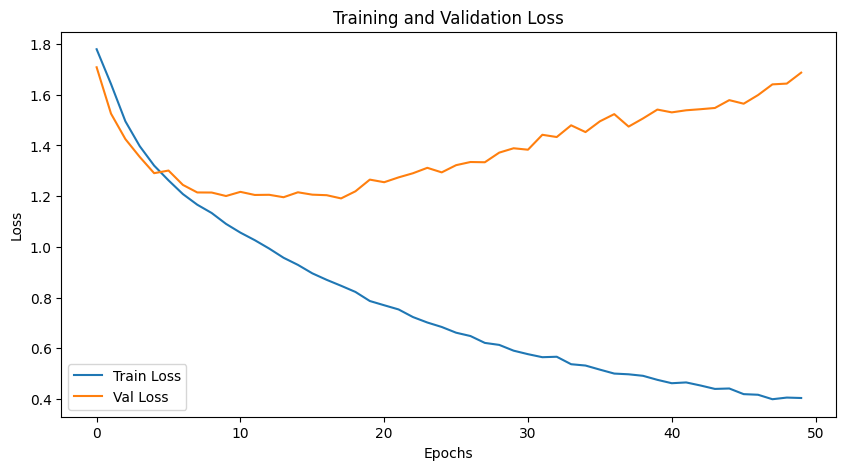

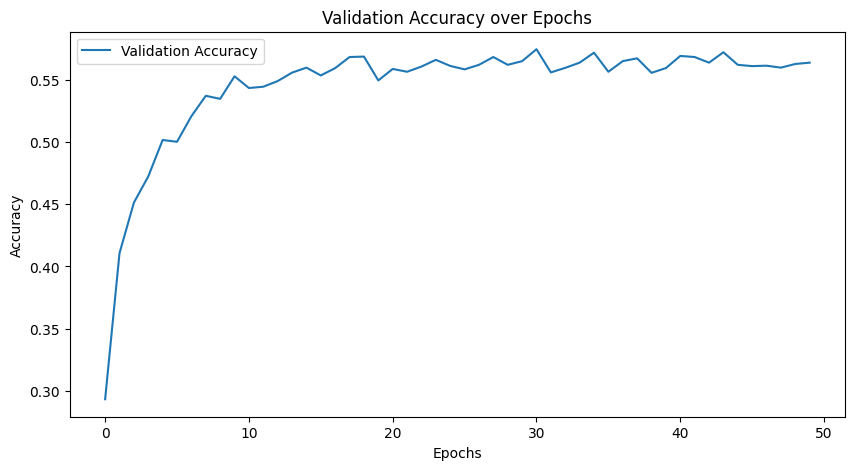

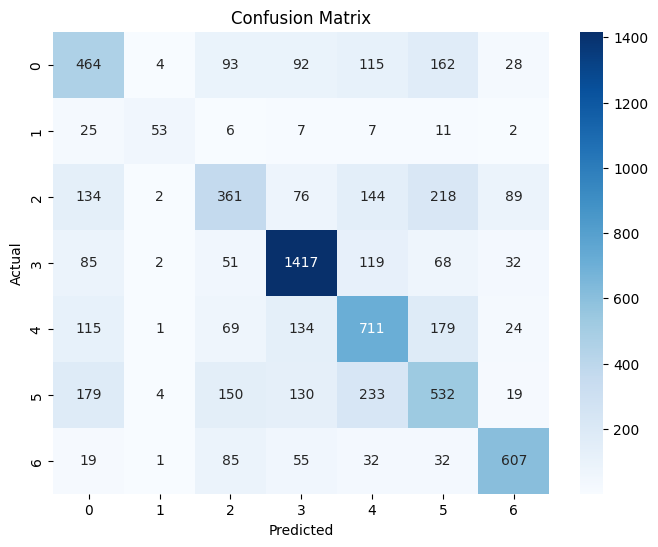

In [11]:
if __name__ == '__main__':
    torch.multiprocessing.freeze_support()

    # Training and validation
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CNN_RNN_FER().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []

    num_epochs = 50
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        correct = total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = correct / total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_rcnn_model.pth")

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.3f}, Val Loss={avg_val_loss:.3f}, Val Acc={val_acc:.3f}")

    # Evaluate on test set
    model.load_state_dict(torch.load("best_rcnn_model.pth"))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print("Test Set Classification Report:")
    print(classification_report(y_true, y_pred))

    # Plotting
    plt.figure(figsize=(10,5))
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy over Epochs')
    plt.show()

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()